# Rate distributions: Time vs distance-weighted

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd
import math

In [17]:
%matplotlib inline

## A function to simulate trajectories. 

In [3]:
def trajectory_simulator(pre_duration = 250, #Mean event start time
                         pre_sigma = 50, #Sigma of event start time distribution
                         post_duration = 250, #The bead stays on for this long at the end of the trajectory
                         mean_duration = 100, #Mean event duration
                         min_duration = 10, #Minimum event duration
                         mean_rate = 500, #Mean rate (distance units/timestep)
                         rate_sigma = 50, #Sigma of the rate distribution
                         noise_sigma = 500, #Mean sigma for the bead movement
                         noise_sigma_sigma = 100, #Sigma of the noise sigma distribution
                         pause_prob = 0.001, #Probability of entering a pause in a given timestep
                         pause_duration_prob = 0.2, #Probability of remaining paused in a given timestep once a pause has begun.
                         rate_change_prob = 0.1, #Probablity that the rate will change in a given timestep
                         DNA_length = 15000, #Length of the DNA - a hard limit on the event length
                         trajectory_number = 0):
    length = int(np.random.exponential(mean_duration)) #Length is drawn from an exponential distribution.
    while length < min_duration:
        length = int(np.random.exponential(mean_duration)) #The length should be at least a certain value.
        
    current_rate = 0
    pre = int(np.random.normal(loc=pre_duration, scale = pre_sigma))
    post = post_duration
    rate = 0
    ratesequence = [0]*pre
    noise_sigmaval = int(np.random.normal(loc=noise_sigma, scale = noise_sigma_sigma))
    position = [0]*pre
    nucleotides = []
    current_position = 0
    for i in range(0,pre):
        nucleotides.append(float(position[i]+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    for i in range(0,length):
        randomnumber = random.random() #generate a random float between 0 and 1
        if i == 0: #Start the event
            rate =  np.random.normal(loc=mean_rate, scale = rate_sigma)            
        elif not rate == 0: #When during an event/no pause.
            if (randomnumber <= pause_prob): #Start a pause.
                rate = 0
            elif (randomnumber > pause_prob) & (randomnumber <= (pause_prob + rate_change_prob)): #Change the rate
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else: #No rate change
                rate = rate #just FYI!         
        elif (rate == 0) & (not i ==0): #When in a pause.
            if (randomnumber < (1- pause_duration_prob)): #End the pause.
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else:
                rate = 0 #Continue the pause.
        ratesequence.append(rate)
        current_position = current_position + rate
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
        if current_position > DNA_length:
            length = i
            break
    for i in range(0,post):
        ratesequence.append(0)
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    time = range(0,len(nucleotides))
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : nucleotides,
                           'rate' : ratesequence,
                           'position' : position})
    results['trajectory'] = trajectory_number
    return results

## Simulation of a large number of events

Generate a large results table.

In [4]:
phi29results = pd.DataFrame()
for j in range(0,1000):
    temp = trajectory_simulator(pre_duration = 300,
                         pre_sigma = 20,
                         post_duration = 250, 
                         mean_duration = 100,
                         min_duration = 10,
                         mean_rate = 80,
                         rate_sigma = 40,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.5,
                         rate_change_prob = 0.01,
                         DNA_length = 15000,
                         trajectory_number = j)
    phi29results = phi29results.append(temp)

In [5]:
phi29results.head()

,nucleotides,position,rate,time,trajectory
0,-12.961563,0.0,0.0,0,0
1,-29.056411,0.0,0.0,1,0
2,0.266135,0.0,0.0,2,0
3,-1.871594,0.0,0.0,3,0
4,-74.424039,0.0,0.0,4,0


In this case, the info we are interested in is the rate column - this has not had noise added to it. The rates are drawn from a normal distribution centred at 80 nt/s, with a standard deviation of 40 nt/s. Each row is implicitly one second, and the distance travelled in each time step is therefore numerically equal to the rate.

## Time-weighted rate distribution

Make a normal distribution with sigma and mu the same as those specified in the simulator.

In [116]:
def pdf(sigma, mu, x_range):
    x = x_range
    y = []
    for i in x:
        y.append((1/(math.sqrt(2*3.14159*sigma**2)))*(math.exp(-1*(((i - (mu))**2) / (2*sigma**2)))))
    return x,y

In [117]:
x,y = pdf(40, 80,np.arange(0,250,1.0))

Plot the rate distribution and overlay the above pdf.

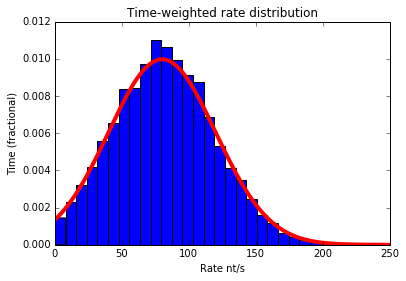

In [184]:
plt.hist(phi29results.rate[phi29results.rate > 0], bins =  30, normed = True)
plt.plot(x,y,color="red", lw = 4)
plt.title("Time-weighted rate distribution")
plt.xlabel("Rate nt/s")
plt.ylabel("Time (fractional)")

A key point to note here is that rates are implicitly time-weighted. If you were to fit line segments and make each segment an equal-contributor to the rate distribution, then the distribution would look quite different.

## Distance-weighted rate distribution

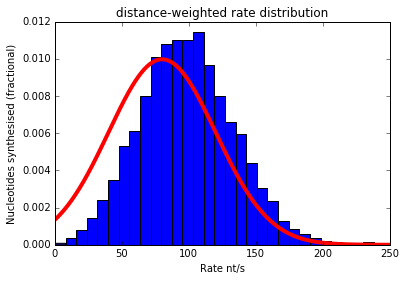

In [78]:
plt.hist(phi29results.rate[phi29results.rate > 0], bins =  30, weights = phi29results.rate[phi29results.rate > 0], normed = True)
plt.plot(x,y,color="red", lw = 4)
plt.title("distance-weighted rate distribution")
plt.xlabel("Rate nt/s")
plt.ylabel("Nucleotides synthesised (fractional)")

Not a very good fit. Distance weighting shifts the distribution to the right, and also narrows it. So what <i>is</i> a good fit?

Let's change sigma and mu to something more likely to fit well:

In [135]:
x,y = pdf(35, 98,np.arange(0,250,1.0))

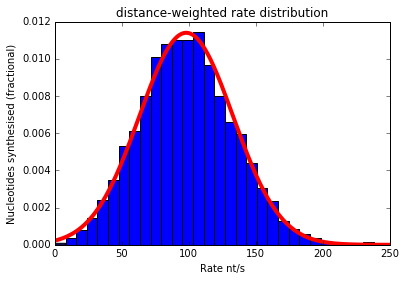

In [136]:
plt.hist(phi29results.rate[phi29results.rate > 0], bins =  30, weights = phi29results.rate[phi29results.rate > 0], normed = True)
plt.plot(x,y,color="red",lw=4)
plt.title("distance-weighted rate distribution")
plt.xlabel("Rate nt/s")
plt.ylabel("Nucleotides synthesised (fractional)")

This fit is OK for a guess, but how can we get there from first principles? Let's multiply by x and normalise, i.e. the same thing we did to the histogram.

In [168]:
x,y = pdf(40, 80,np.arange(0,250,1.0)) #regenerate the original pdf with sigma = 40 and mu = 80
a = []
for i in range(0,len(x)):
    a.append(y[i]*i) #Multiply y by x
asum = sum(a)
z = []
for i in a:
    z.append(i/asum) #Normalise

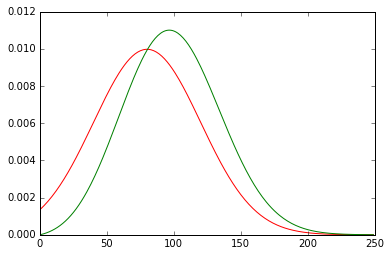

In [169]:
plt.plot(x,y,color="red")
plt.plot(x,z,color="green")

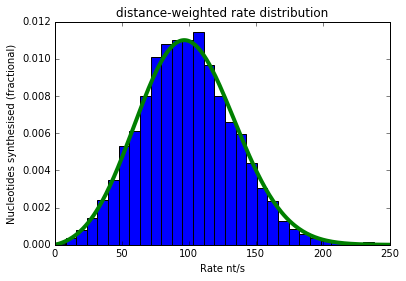

In [170]:
plt.hist(phi29results.rate[phi29results.rate > 0], bins =  30, weights = phi29results.rate[phi29results.rate > 0], normed = True)
plt.plot(x,z,color="green",lw=4)
plt.title("distance-weighted rate distribution")
plt.xlabel("Rate nt/s")
plt.ylabel("Nucleotides synthesised (fractional)")

Perfect, but so far this is merely a tautology: Making the equivalent adjustment to the pdf and the histogram it describes means that they will continue to fit to each other. Let's summarise the the adjustment we have made in a function which describes our new pdf:

In [183]:
def weighted_pdf(sigma, mu, x_range):
    x = x_range
    a = []
    for i in x:
        a.append(((i/(math.sqrt(2*3.14159*sigma**2)))*(math.exp(-1*(((i - (mu))**2) / (2*sigma**2))))))
        #Note that x is now in the numerator of the first part of the Gaussian function.
    y = []
    for i in a:
        y.append(i/sum(a))
    return x,y

In [179]:
x,y = pdf(40,80,np.arange(0,250,1.0))
x, z = weighted_pdf(40,80,np.arange(0,250,1.0))

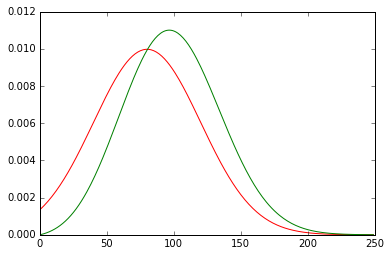

In [182]:
plt.plot(x,y,color="red")
plt.plot(x,z,color="green")

https://math.stackexchange.com/questions/2298297/gaussian-multiplied-by-x-axis-values#2298297